<a href="https://colab.research.google.com/github/gpricechristie/introductionToClinicalTrials/blob/main/simulateTrials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation of different clinical trial designs
Load a simulated cancer pateint population, sample from the population and assess the impact of different designs on the study analysis

Basic patient factors in the population are:
* Age
* Sex
* Performance status
* Cancer stage
* GTV Volume


Load libraries

In [56]:
install.packages("ggsurvfit")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [57]:
install.packages("table1")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [58]:
library(survival)
library(ggplot2)
library(ggsurvfit)
library(tidyr)
library(table1)
library(patchwork)
library(dplyr)

Load population data

In [59]:
population = read.csv('simulatedPopulation.csv')
population$ps = as.factor(population$ps)
population$sex = as.factor(population$sex)
population$stage = as.factor(population$stage)

Create demographic table and plot descriptive statistics

In [60]:
tab1 = table1(~ age + sex + ps + stage + gtv, population)

Warning message:
“Removed 537 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


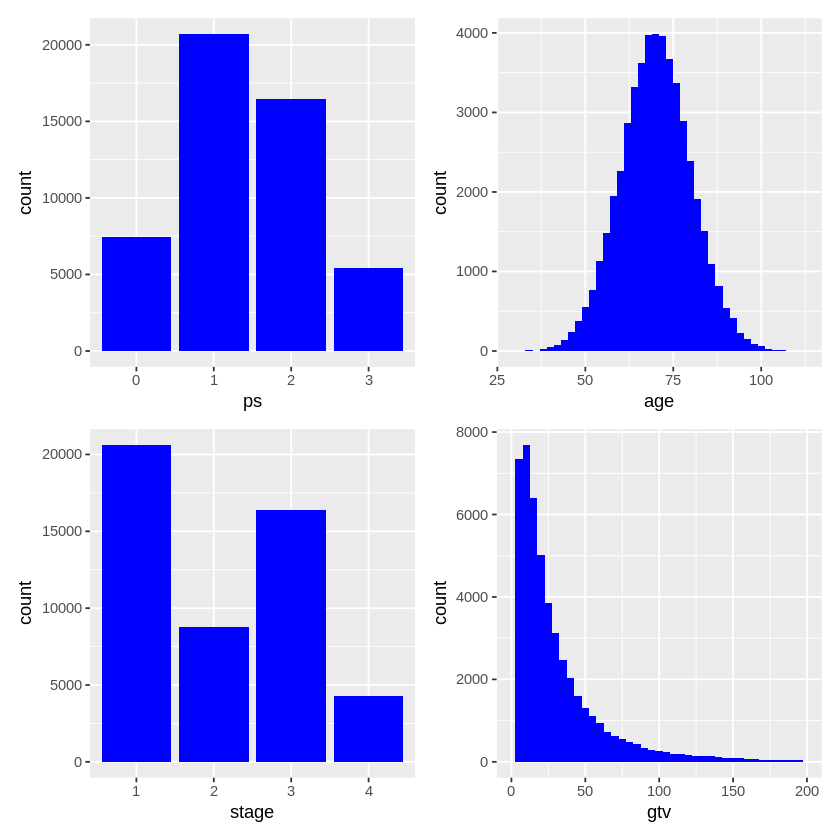

In [61]:
p1 = ggplot(population,aes(x=ps)) +
  geom_bar(stat='count', fill='blue')
p2 = ggplot(population,aes(x=age)) +
  geom_histogram(fill='blue',binwidth=2)
p3 = ggplot(population,aes(x=stage)) +
  geom_bar(stat='count', fill='blue')
p4 = ggplot(population,aes(x=gtv)) +
  geom_histogram(fill='blue',binwidth=5) +
  xlim(c(0,200))
p1+p2+p3+p4

Set basic parameters


*   Number of patients to sample from population (nbrPats)
*   Baseline hazard for simulation of survival times (h_0 - uniform as exponential cumulative baseline)



In [62]:
nbrPats = 1000
popSize=nrow(population)
h_0=0.001

Create time vector for period we are interested in (3 years)

In [63]:
time=seq(0,365*3)

Calculate cumulative baseline hazard

In [64]:
H_0 = h_0 * time

#Clinical scenarios
Provide new intervention under different scenarios and evaluate its impact on survival

Sample patients from the wider population to include in study

In [65]:
set.seed(86112)
patients=population[as.integer(runif(nbrPats)*popSize),]

##Treatment assigned by hospital


Assign patients to catchement area for:
* Hospital A - catchment area predominantly affluent suburbs
* Hospital B - catchment area includes more deprived inner city regions

In [66]:
patients$treat = rep('Standard of Care',nrow(patients))
patients$treat[which(patients$hospital=='A')]='Intervention'

Add treatment to prognostic index

In [67]:
patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

Now need to simulate survival times by using probabilities taken from a uniform random number generator for each patient

They then survive until the corresponding time equating to the survival probability calculated from their individual hazard radio

S(t) = exp(-H_0(t) * exp(progInd)) where we calculate S(t) from random distribution for each patient

log(S(t)) = -h_0 * time * exp(progInd)

time = - log(S(t)) / h_0*exp(progInd)

In the first instance set all patinets to having an event (ie we know when all die). We can censoir later if required

In [68]:
survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Use ggplot to plot KM curve

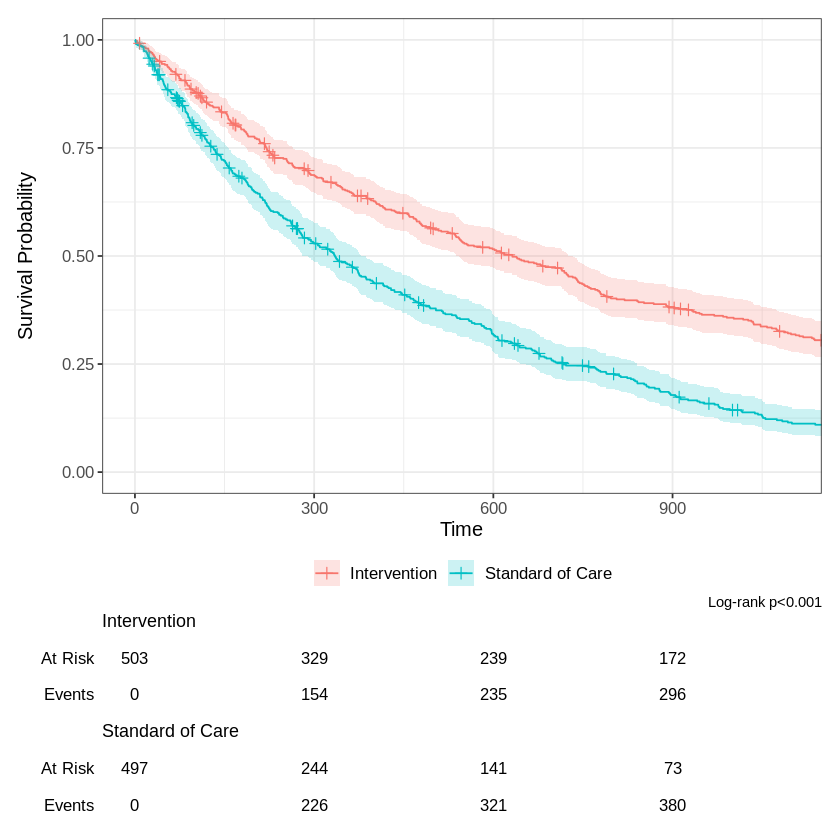

In [69]:
hospitalSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(hospitalSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")

However, look at balance between those patients who recieved the new treatments (that attended hospital A) and those that didn't (that attended hospital B).

Note to get the below table to render (TODO: figure out how to render directly in notebook) you need to copy the html output to the empty text box below the code snippet

In [70]:
print(table1(~ age + sex + ps + stage | treat, patients))

<table class="Rtable1">
<thead>
<tr>
<th class='rowlabel firstrow lastrow'></th>
<th class='firstrow lastrow'><span class='stratlabel'>Intervention<br><span class='stratn'>(N=503)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Standard of Care<br><span class='stratn'>(N=497)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Overall<br><span class='stratn'>(N=1000)</span></span></th>
</tr>
</thead>
<tbody>
<tr>
<td class='rowlabel firstrow'>age</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>66.2 (9.39)</td>
<td>72.5 (9.13)</td>
<td>69.3 (9.76)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>66.2 [37.5, 93.6]</td>
<td class='lastrow'>72.7 [44.1, 96.6]</td>
<td class='lastrow'>69.7 [37.5, 96.6]</td>
</tr>
<tr>
<td class='rowlabel firstrow'>sex</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='



<table class="Rtable1">
<thead>
<tr>
<th class='rowlabel firstrow lastrow'></th>
<th class='firstrow lastrow'><span class='stratlabel'>Intervention<br><span class='stratn'>(N=503)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Standard of Care<br><span class='stratn'>(N=497)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Overall<br><span class='stratn'>(N=1000)</span></span></th>
</tr>
</thead>
<tbody>
<tr>
<td class='rowlabel firstrow'>age</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>66.2 (9.39)</td>
<td>72.5 (9.13)</td>
<td>69.3 (9.76)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>66.2 [37.5, 93.6]</td>
<td class='lastrow'>72.7 [44.1, 96.6]</td>
<td class='lastrow'>69.7 [37.5, 96.6]</td>
</tr>
<tr>
<td class='rowlabel firstrow'>sex</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>female</td>
<td>199 (39.6%)</td>
<td>195 (39.2%)</td>
<td>394 (39.4%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>male</td>
<td class='lastrow'>304 (60.4%)</td>
<td class='lastrow'>302 (60.8%)</td>
<td class='lastrow'>606 (60.6%)</td>
</tr>
<tr>
<td class='rowlabel firstrow'>ps</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>0.954 (0.763)</td>
<td>1.81 (0.776)</td>
<td>1.38 (0.881)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>1.00 [0, 3.00]</td>
<td class='lastrow'>2.00 [0, 3.00]</td>
<td class='lastrow'>1.00 [0, 3.00]</td>
</tr>
<tr>
<td class='rowlabel firstrow'>stage</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>1.58 (0.861)</td>
<td>2.61 (0.936)</td>
<td>2.09 (1.03)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>1.00 [1.00, 4.00]</td>
<td class='lastrow'>3.00 [1.00, 4.00]</td>
<td class='lastrow'>2.00 [1.00, 4.00]</td>
</tr>
</tbody>
</table>



Plotted as graphs

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


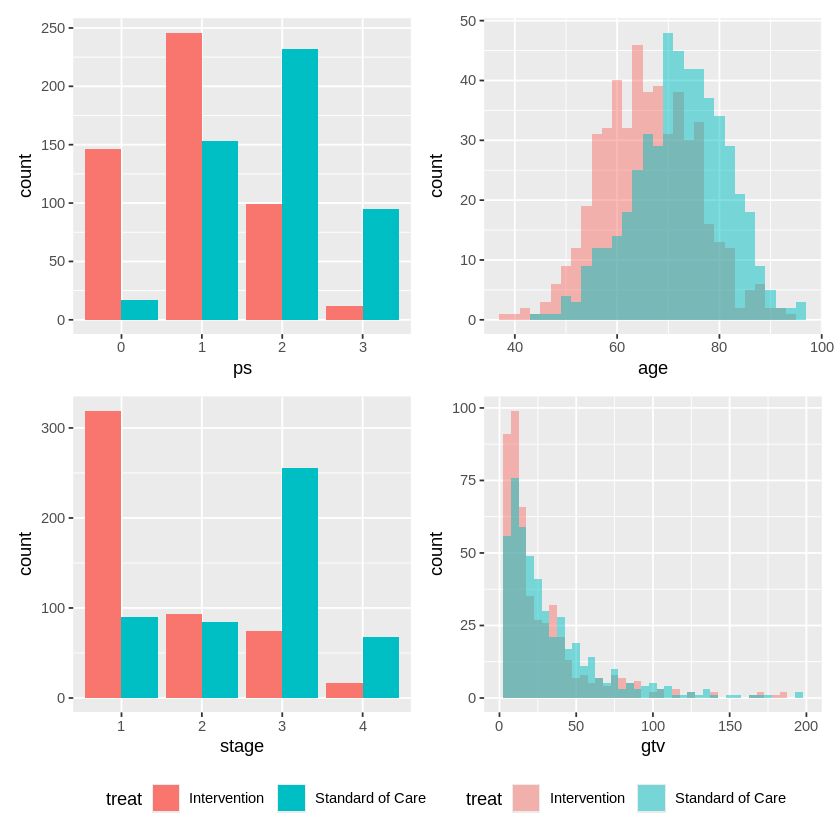

In [71]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

However, calculate the multivariable cox model and see what the regression coefficients say

In [72]:
hospitalCox = coxph(hospitalSurv~ age + factor(sex) + factor(ps) + factor(stage) + log(gtv) + treat, data=patients)
summary(hospitalCox)

Call:
coxph(formula = hospitalSurv ~ age + factor(sex) + factor(ps) + 
    factor(stage) + log(gtv) + treat, data = patients)

  n= 1000, number of events= 900 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.009315  1.009359 0.003842 2.424  0.01534 *  
factor(sex)male       0.276547  1.318570 0.069736 3.966 7.32e-05 ***
factor(ps)1           0.240297  1.271627 0.102056 2.355  0.01854 *  
factor(ps)2           0.356427  1.428218 0.116029 3.072  0.00213 ** 
factor(ps)3           0.654073  1.923359 0.152093 4.300 1.70e-05 ***
factor(stage)2        0.241811  1.273554 0.100391 2.409  0.01601 *  
factor(stage)3        0.469827  1.599718 0.099639 4.715 2.41e-06 ***
factor(stage)4        0.802270  2.230599 0.144295 5.560 2.70e-08 ***
log(gtv)              0.308141  1.360893 0.036318 8.484  < 2e-16 ***
treatStandard of Care 0.082581  1.086087 0.100423 0.822  0.41089    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           

##Treatment assigned randomly to all patients
In the next scenario, treatment is assigned randonly to all patients

The randomisation balances the groups meaning the log-rank test results closely agree with the multivariable regression

Create the new survival data

In [73]:
patients$treat = rep('Standard of Care',nbrPats)
patients$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Look at KM curve

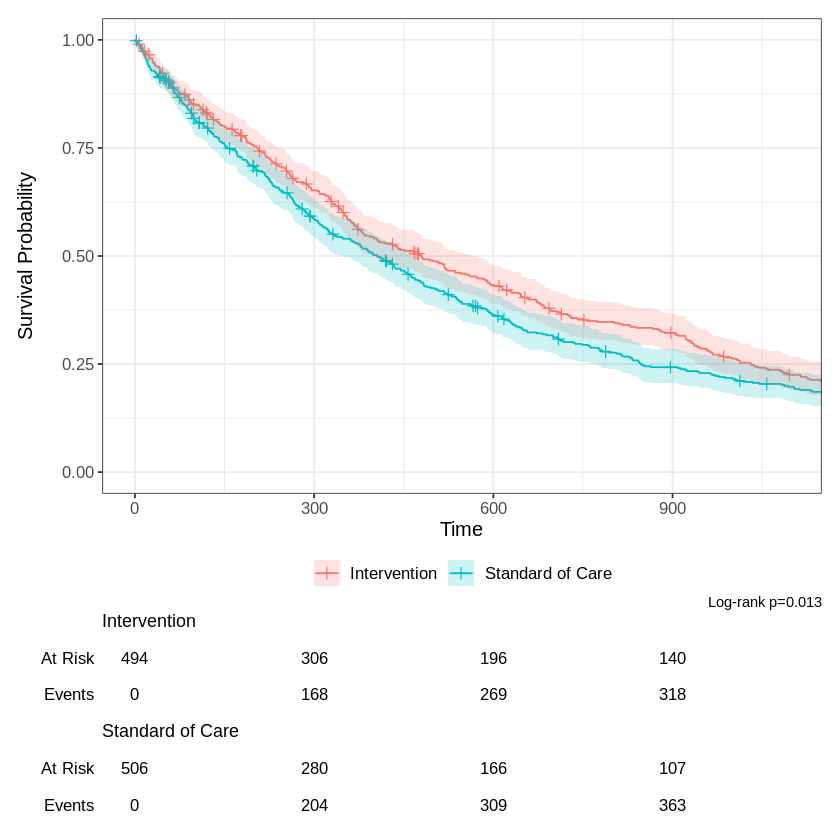

In [74]:
randSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(randSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")


Plot balance of groups

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


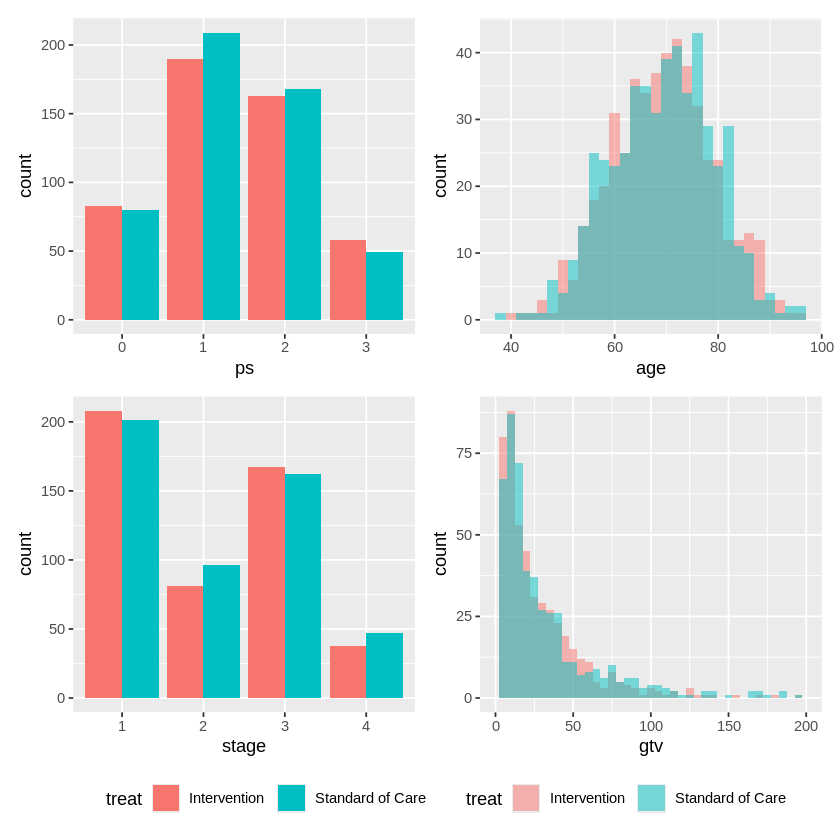

In [75]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

Check multi variable analysis

In [76]:
randCox = coxph(randSurv~ age + factor(sex) + factor(ps) + factor(stage) + log(gtv) + treat, data=patients)
summary(randCox)

Call:
coxph(formula = randSurv ~ age + factor(sex) + factor(ps) + factor(stage) + 
    log(gtv) + treat, data = patients)

  n= 1000, number of events= 906 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.015123  1.015238 0.003575 4.230 2.33e-05 ***
factor(sex)male       0.300066  1.349948 0.069950 4.290 1.79e-05 ***
factor(ps)1           0.338206  1.402430 0.098293 3.441  0.00058 ***
factor(ps)2           0.440890  1.554089 0.105690 4.172 3.03e-05 ***
factor(ps)3           0.749865  2.116715 0.133480 5.618 1.93e-08 ***
factor(stage)2        0.257357  1.293507 0.096783 2.659  0.00783 ** 
factor(stage)3        0.486820  1.627134 0.083339 5.841 5.17e-09 ***
factor(stage)4        0.838056  2.311868 0.129084 6.492 8.45e-11 ***
log(gtv)              0.276896  1.319029 0.038441 7.203 5.89e-13 ***
treatStandard of Care 0.143568  1.154385 0.067322 2.133  0.03296 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               

##Randomisation with selection criteria
In the final scenario we demonstrate why trials have selection criteria. As some patients respond differently to the new treatment, selection of only those patients expected to respond positively to the intervention can lead to more impressive results

Select patients from the population limited to those with
* Performance status 0-1
* Stage 1-2

In [77]:
patients_included = population %>%
  dplyr::filter((ps == 0 | ps ==1) & (stage == 1 | stage == 2)) %>%
  slice_sample(n=nbrPats)

Randomise this subset of patients and repeat the analysis

In [78]:
patients_included$treat = rep('Standard of Care',nbrPats)
patients_included$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients_included$treat_pi = log(patients_included$hr_treat) * (patients_included$treat == 'Intervention')
patients_included$progInd = patients_included$baseProgInd + patients_included$treat_pi

survProb = runif(nbrPats,0,1)
patients_included$survTime = -log(survProb) / (h_0 * exp(patients_included$progInd))
patients_included$vitalStatus = rbinom(n=nbrPats, size=1, prob=0.9)

Look at KM curve and Cox regression, check cohort balance

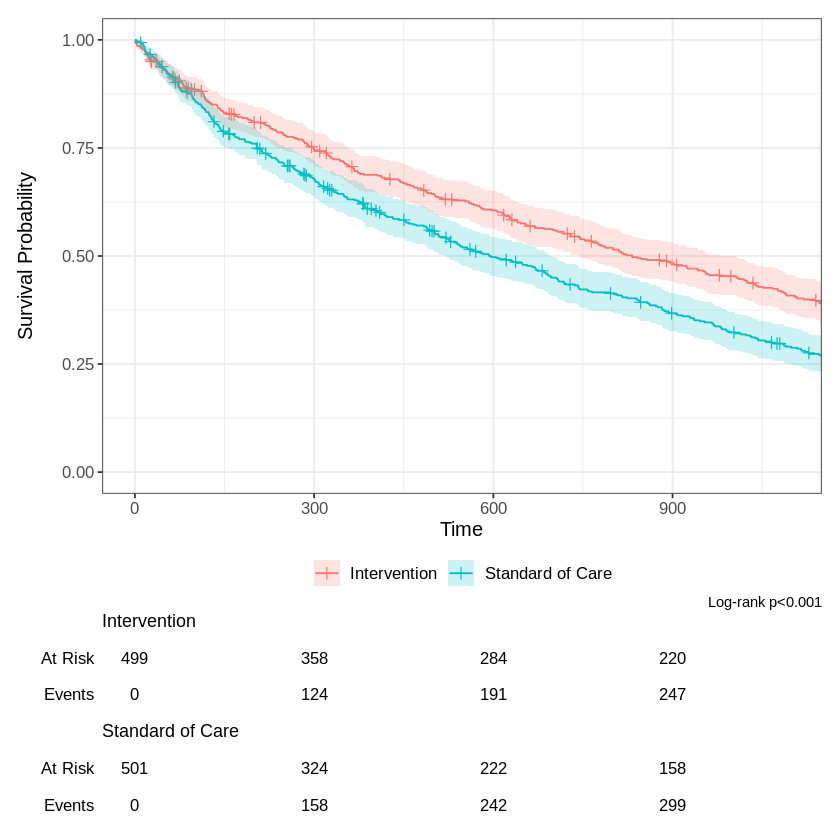

In [79]:
selectSurv = Surv(patients_included$survTime,patients_included$vitalStatus)

ggsurvfit(survfit2(selectSurv~treat, data=patients_included), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")

Look at group balance and Cox multivariable regression

Warning message:
“Removed 7 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


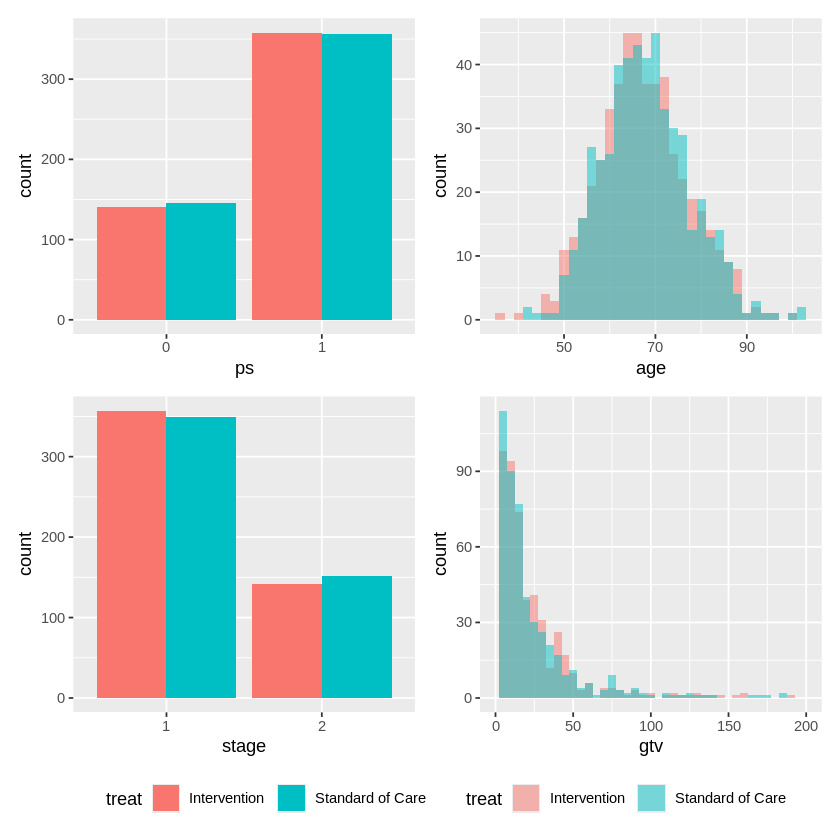

In [80]:
p1 = ggplot(patients_included,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients_included,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients_included,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients_included,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

In [81]:
selectCox = coxph(selectSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients_included)
summary(selectCox)

Call:
coxph(formula = selectSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients_included)

  n= 1000, number of events= 883 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.007580  1.007609 0.003603 2.104 0.035371 *  
sexmale               0.252685  1.287478 0.070100 3.605 0.000313 ***
ps1                   0.374893  1.454835 0.077445 4.841 1.29e-06 ***
ps2                         NA        NA 0.000000    NA       NA    
ps3                         NA        NA 0.000000    NA       NA    
stage2                0.367466  1.444071 0.074918 4.905 9.35e-07 ***
stage3                      NA        NA 0.000000    NA       NA    
stage4                      NA        NA 0.000000    NA       NA    
log(gtv)              0.338230  1.402462 0.036408 9.290  < 2e-16 ***
treatStandard of Care 0.361441  1.435396 0.068853 5.249 1.53e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(co

##Performance outside of trial selection criteria

In the above example the new treatment showed good performance, but was only tested in patients with
* Performance status 0-1
* Stage 1-2

Generalisability refers to the extent to which evidence from trials with selection criteria can be applied to the wider patient population. In reality, new interventions can sometimes be rolled out across departments based on results from a subset of the population they will be used for.

Here we examine the performance of the above treatment in the section of the population not included in the trial.

Select patients from the population limited to those with
* Performance status 2+
* Stage 3+

In [82]:
patients_excluded = population %>%
  dplyr::filter((ps == 2 | ps ==3 | ps == 4 | ps ==5) & (stage == 3 | stage == 4)) %>%
  slice_sample(n=nbrPats)

Randomise this subset of patients and repeat the analysis

In [83]:
patients_excluded$treat = rep('Standard of Care',nbrPats)
patients_excluded$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients_excluded$treat_pi = log(patients_excluded$hr_treat) * (patients_excluded$treat == 'Intervention')
patients_excluded$progInd = patients_excluded$baseProgInd + patients_excluded$treat_pi

survProb = runif(nbrPats,0,1)
patients_excluded$survTime = -log(survProb) / (h_0 * exp(patients_excluded$progInd))
patients_excluded$vitalStatus = rbinom(n=nbrPats, size=1, prob=0.9)

Look at KM curve and Cox regression, check cohort balance

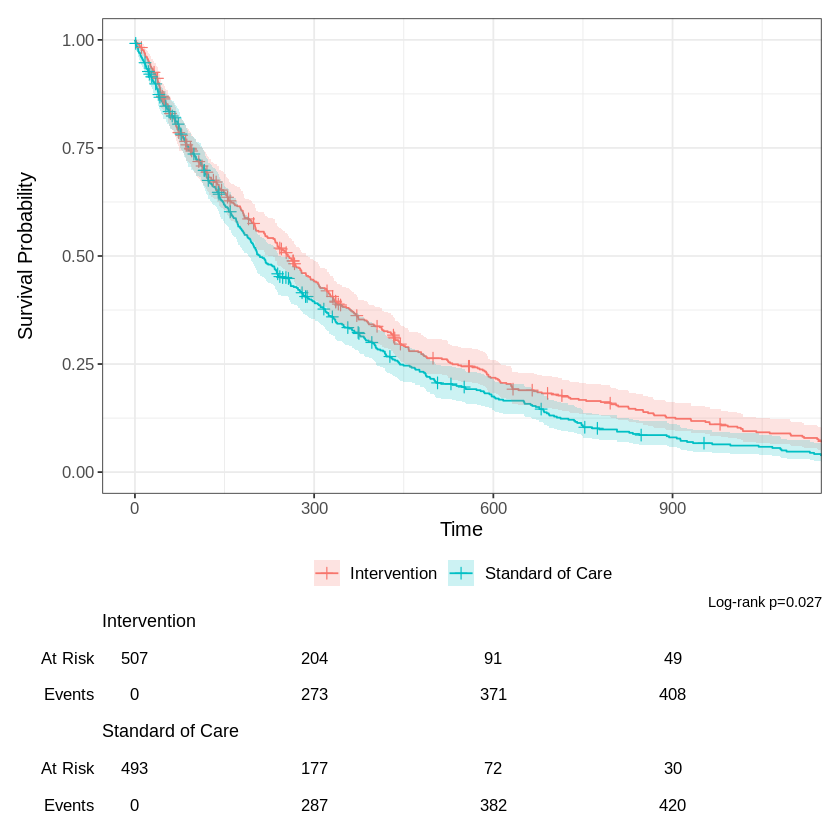

In [84]:
selectSurv = Surv(patients_excluded$survTime,patients_excluded$vitalStatus)

ggsurvfit(survfit2(selectSurv~treat, data=patients_excluded), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")

Look at group balance and Cox regression

Warning message:
“Removed 20 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


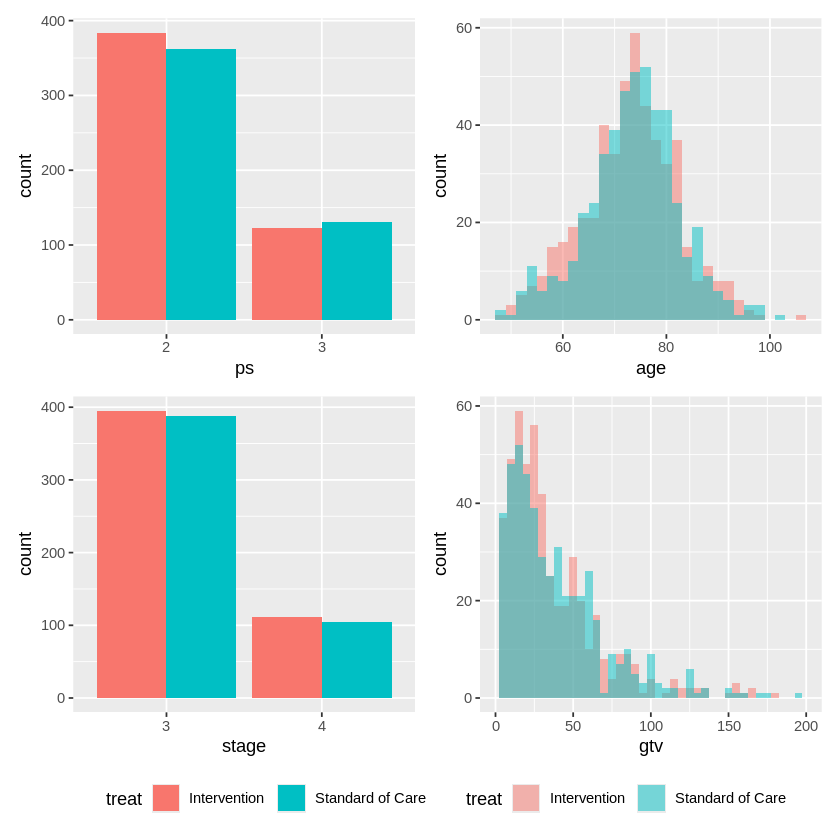

In [85]:
p1 = ggplot(patients_excluded,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients_excluded,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients_excluded,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients_excluded,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

In [88]:
patients_excluded$ps = relevel(patients_excluded$ps, ref = '2')
patients_excluded$stage = relevel(patients_excluded$stage, ref = '3')
excludeCox = coxph(selectSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients_excluded)
summary(excludeCox)

Call:
coxph(formula = selectSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients_excluded)

  n= 1000, number of events= 900 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.010059  1.010110 0.003695 2.722 0.006482 ** 
sexmale               0.266195  1.304990 0.068875 3.865 0.000111 ***
ps0                         NA        NA 0.000000    NA       NA    
ps1                         NA        NA 0.000000    NA       NA    
ps3                   0.075796  1.078742 0.077438 0.979 0.327680    
stage1                      NA        NA 0.000000    NA       NA    
stage2                      NA        NA 0.000000    NA       NA    
stage4                0.189237  1.208327 0.082427 2.296 0.021686 *  
log(gtv)              0.305955  1.357922 0.035921 8.518  < 2e-16 ***
treatStandard of Care 0.158759  1.172055 0.067357 2.357 0.018424 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(co